# Train a Model for Fruit Classification using Tensorflow / Keras
&copy; 2021 by Michael Stanley (Mike.Stanley@ieee.org)<BR>
Last revised: 28 May 2021

This notebook demonstrates the process of training a model using TensorFlow and converting it for use with TensorFlow Lite for Microcontrollers. 

The model in question accepts a 1x3 vector containing normalaized sensor samples and converts this to a one-hot encoding of 0|1|2|3, which corresponds to 'Bananas', 'Oranges','RedApples' and 'GreenApples', respectively.

This is the TensorFlow version of the Fruit_Classification notebook, which uses classical ML techniques.  Rather than repeat the initial data transformation/munging done there, we'll just pick up and use the features.csv exported by that notebook as our starting point.

The model was derived from the standard Tensorflow-Lite [hello_world] example, but has been heavily modified.

Reference: (https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) example for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview).
![Misc. Fruits](../images/Fruit/fruits.png)    

# Import dependencies and set random number seeds

In [1]:
import os
import numpy as np
np.random.seed(1) # numpy seed
import tensorflow as tf
tf.random.set_seed(1) # tensorflow global random seed
from tensorflow import keras # Keras is TensorFlow's high-level API for deep learning
import matplotlib.pyplot as plt # Matplotlib is a graphing library
import math # Math is Python's math library
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.utils import np_utils
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# set default font for charts
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# Dataset

## Import Data
<b>This notebook consumes features.csv, which was created by Fruit_Classification.ipynb.  The data has already been normalized and shuffled into a random order</b>

In [3]:
classNames = ['Bananas', 'Oranges','RedApples','GreenApples']
fn = 'FruitFiles/features.csv'
data = pd.read_csv(fn)
results=data['Class'].astype(int)
features = data.drop(['Class'], axis=1)
display(features.head())
display(results.head())
# List out the unique class assignments as a check (should be 0 through 3).
results.unique()

,Rnorm,Gnorm,Bnorm
0,0.470238,0.327381,0.232143
1,0.390244,0.439024,0.243902
2,0.571429,0.214286,0.285714
3,0.495050,0.316832,0.227723
4,0.538462,0.230769,0.307692


0    0
1    3
2    2
3    0
4    2
Name: Class, dtype: int32

array([0, 3, 2, 1], dtype=int64)

# Split data into training and test sets
To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing). This particular model replicates an experiment already done using scikit-learn, so we're only doing a two-way split to check for consistency with earlier results.

The data is split as follows:

Training: 67%
Testing: 33%

In [4]:
x_train, x_test, y_train, y_test = train_test_split(features.to_numpy(), results.to_numpy(), test_size=0.33, random_state=37)

# Subroutine for XY plots: myScatter()
This utility function can create an XY plot of two features found in the input table.  We use it here to look at 2D slices of our 3D data.

This particular function works with numpy arrays only.

Normalized input data


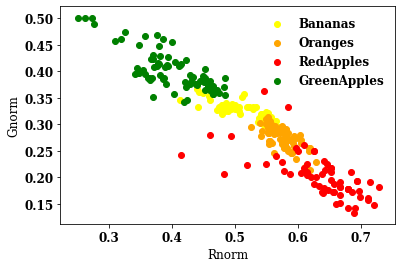

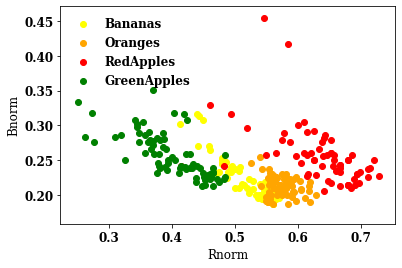

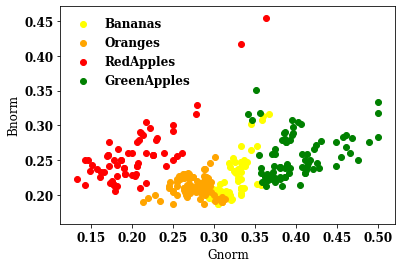

In [5]:
def myScatter(featureNames, X, idx0, idx1, Y):
    labels=['Off', 'Low', 'Medium', 'High']
    color = ['yellow', 'orange', 'red', 'green']
    fig, ax = plt.subplots()
    x0 = X[:,idx0]
    x1 = X[:,idx1]
    for g in np.unique(Y):
        ix = np.where(g==Y)
        c=color[g]
        ax.scatter(x0[ix], x1[ix], c=c, label=labels[g])
    plt.legend(loc='best', frameon=False, labels=['Bananas', 'Oranges', 'RedApples', 'GreenApples'])
    plt.xlabel(featureNames[idx0])
    plt.ylabel(featureNames[idx1])

print('Normalized input data')
myScatter(features.columns, x_train, 0, 1, y_train)
myScatter(features.columns, x_train, 0, 2, y_train)
myScatter(features.columns, x_train, 1, 2, y_train)


# Design the model
We're going to build a simple neural network model that will take a three-feature input value and use it to predict 1 of 4 class membership. 

**Note:** To learn more about how neural networks function, you can explore the [Learn TensorFlow](https://codelabs.developers.google.com/codelabs/tensorflow-lab1-helloworld) codelabs.

The code in the following cell defines our model using [Keras](https://www.tensorflow.org/guide/keras), TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we _compile_ it, specifying parameters that determine how it will be trained:

In [6]:
# We'll use Keras to create a simple model architecture
model_1 = tf.keras.Sequential()

# First layer takes a three scalar input and feeds it through 4 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(keras.layers.Dense(12, kernel_regularizer=keras.regularizers.l2(0.001),
                               activation='relu', input_shape=(3,)))
model_1.add(keras.layers.Dense(6, kernel_regularizer=keras.regularizers.l2(0.001),
                               activation='relu'))


# Final layer is a one-hot, since we want to output a single value
model_1.add(keras.layers.Dense(4, activation=tf.nn.softmax))
model_1.summary()
# Compile the model using a standard optimizer and loss function for regression
model_1.compile(optimizer='adam', learning_rate=0.0001, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 28        
Total params: 154
Trainable params: 154
Non-trainable params: 0
_________________________________________________________________


# Train the model
Once we've defined the model, we can use our data to _train_ it. Training involves passing an `x` value into the neural network, checking how far the network's output deviates from the expected `y` value, and adjusting the neurons' weights and biases so that the output is more likely to be correct the next time.

Training runs this process on the full dataset multiple times, and each full run-through is known as an <b>epoch</b>. The number of epochs to run during training is a parameter we can set.

During each epoch, data is run through the network in multiple _batches_. In each batch, several pieces of data are passed into the network, producing output values. These outputs' correctness is measured in aggregate and the network's weights and biases are adjusted accordingly, once per batch. The _batch size_ is also a parameter we can set.

The code in the following cell uses the `x` and `y` values from our training data to train the model. It runs for 500 _epochs_, with 25 pieces of data in each _batch_. We also pass in some data for _validation_. As you will see when you run the cell, training can take a while to complete:



In [7]:
one_hot_ytrain = np_utils.to_categorical(y_train)
one_hot_ytest = np_utils.to_categorical(y_test)

In [8]:
# Train the model on our training data while validating on our test set
history_1 = model_1.fit(x_train, one_hot_ytrain, epochs=500, batch_size=25, validation_data=(x_test, one_hot_ytest))

print("Training set score:")
model_1.evaluate(x_train, one_hot_ytrain, verbose=2)
print("Test set score: ")
model_1.evaluate(x_test, one_hot_ytest, verbose=2)

Train on 285 samples, validate on 141 samples
Epoch 1/500
285/285 [==============================] - 1s 3ms/sample - loss: 1.4080 - accuracy: 0.2175 - val_loss: 1.4208 - val_accuracy: 0.1702
Epoch 2/500
285/285 [==============================] - 0s 210us/sample - loss: 1.4022 - accuracy: 0.1404 - val_loss: 1.4124 - val_accuracy: 0.2340
Epoch 3/500
285/285 [==============================] - 0s 189us/sample - loss: 1.3978 - accuracy: 0.2772 - val_loss: 1.4071 - val_accuracy: 0.2340
Epoch 4/500
285/285 [==============================] - 0s 179us/sample - loss: 1.3953 - accuracy: 0.2772 - val_loss: 1.4030 - val_accuracy: 0.2340
Epoch 5/500
285/285 [==============================] - 0s 196us/sample - loss: 1.3932 - accuracy: 0.2772 - val_loss: 1.4007 - val_accuracy: 0.2340
Epoch 6/500
285/285 [==============================] - 0s 165us/sample - loss: 1.3920 - accuracy: 0.2772 - val_loss: 1.3982 - val_accuracy: 0.2340
Epoch 7/500
285/285 [==============================] - 0s 193us/sample - l

285/285 [==============================] - 0s 161us/sample - loss: 0.8647 - accuracy: 0.7158 - val_loss: 0.7970 - val_accuracy: 0.7872
Epoch 112/500
285/285 [==============================] - ETA: 0s - loss: 0.8785 - accuracy: 0.68 - 0s 147us/sample - loss: 0.8608 - accuracy: 0.7123 - val_loss: 0.7913 - val_accuracy: 0.7660
Epoch 113/500
285/285 [==============================] - 0s 154us/sample - loss: 0.8564 - accuracy: 0.7298 - val_loss: 0.7893 - val_accuracy: 0.7872
Epoch 114/500
285/285 [==============================] - 0s 151us/sample - loss: 0.8532 - accuracy: 0.7368 - val_loss: 0.7868 - val_accuracy: 0.7943
Epoch 115/500
285/285 [==============================] - 0s 165us/sample - loss: 0.8480 - accuracy: 0.7439 - val_loss: 0.7827 - val_accuracy: 0.8014
Epoch 116/500
285/285 [==============================] - 0s 137us/sample - loss: 0.8439 - accuracy: 0.7439 - val_loss: 0.7774 - val_accuracy: 0.7943
Epoch 117/500
285/285 [==============================] - 0s 140us/sample - los

Epoch 166/500
285/285 [==============================] - 0s 147us/sample - loss: 0.6675 - accuracy: 0.8632 - val_loss: 0.6193 - val_accuracy: 0.9007
Epoch 167/500
285/285 [==============================] - 0s 158us/sample - loss: 0.6646 - accuracy: 0.8596 - val_loss: 0.6159 - val_accuracy: 0.8865
Epoch 168/500
285/285 [==============================] - 0s 140us/sample - loss: 0.6620 - accuracy: 0.8526 - val_loss: 0.6132 - val_accuracy: 0.8865
Epoch 169/500
285/285 [==============================] - 0s 158us/sample - loss: 0.6590 - accuracy: 0.8632 - val_loss: 0.6110 - val_accuracy: 0.9007
Epoch 170/500
285/285 [==============================] - 0s 154us/sample - loss: 0.6565 - accuracy: 0.8772 - val_loss: 0.6099 - val_accuracy: 0.8936
Epoch 171/500
285/285 [==============================] - 0s 161us/sample - loss: 0.6540 - accuracy: 0.8596 - val_loss: 0.6052 - val_accuracy: 0.8794
Epoch 172/500
285/285 [==============================] - 0s 147us/sample - loss: 0.6512 - accuracy: 0.8632

Epoch 221/500
285/285 [==============================] - 0s 158us/sample - loss: 0.5338 - accuracy: 0.9193 - val_loss: 0.5005 - val_accuracy: 0.9007
Epoch 222/500
285/285 [==============================] - 0s 137us/sample - loss: 0.5318 - accuracy: 0.9158 - val_loss: 0.4989 - val_accuracy: 0.9007
Epoch 223/500
285/285 [==============================] - 0s 158us/sample - loss: 0.5299 - accuracy: 0.9158 - val_loss: 0.4965 - val_accuracy: 0.9007
Epoch 224/500
285/285 [==============================] - 0s 140us/sample - loss: 0.5291 - accuracy: 0.9158 - val_loss: 0.4949 - val_accuracy: 0.9078
Epoch 225/500
285/285 [==============================] - 0s 161us/sample - loss: 0.5273 - accuracy: 0.9158 - val_loss: 0.4943 - val_accuracy: 0.9078
Epoch 226/500
285/285 [==============================] - 0s 133us/sample - loss: 0.5248 - accuracy: 0.9123 - val_loss: 0.4921 - val_accuracy: 0.9078
Epoch 227/500
285/285 [==============================] - 0s 158us/sample - loss: 0.5219 - accuracy: 0.9158

Epoch 276/500
285/285 [==============================] - 0s 147us/sample - loss: 0.4444 - accuracy: 0.9333 - val_loss: 0.4226 - val_accuracy: 0.9149
Epoch 277/500
285/285 [==============================] - 0s 161us/sample - loss: 0.4424 - accuracy: 0.9368 - val_loss: 0.4209 - val_accuracy: 0.9149
Epoch 278/500
285/285 [==============================] - 0s 144us/sample - loss: 0.4423 - accuracy: 0.9263 - val_loss: 0.4201 - val_accuracy: 0.9149
Epoch 279/500
285/285 [==============================] - 0s 165us/sample - loss: 0.4398 - accuracy: 0.9298 - val_loss: 0.4189 - val_accuracy: 0.9078
Epoch 280/500
285/285 [==============================] - 0s 140us/sample - loss: 0.4388 - accuracy: 0.9298 - val_loss: 0.4174 - val_accuracy: 0.9149
Epoch 281/500
285/285 [==============================] - 0s 158us/sample - loss: 0.4391 - accuracy: 0.9263 - val_loss: 0.4169 - val_accuracy: 0.9220
Epoch 282/500
285/285 [==============================] - 0s 140us/sample - loss: 0.4381 - accuracy: 0.9333

Epoch 331/500
285/285 [==============================] - 0s 168us/sample - loss: 0.3862 - accuracy: 0.9544 - val_loss: 0.3758 - val_accuracy: 0.9149
Epoch 332/500
285/285 [==============================] - 0s 151us/sample - loss: 0.3835 - accuracy: 0.9509 - val_loss: 0.3745 - val_accuracy: 0.9220
Epoch 333/500
285/285 [==============================] - 0s 151us/sample - loss: 0.3829 - accuracy: 0.9474 - val_loss: 0.3742 - val_accuracy: 0.9291
Epoch 334/500
285/285 [==============================] - 0s 151us/sample - loss: 0.3827 - accuracy: 0.9509 - val_loss: 0.3732 - val_accuracy: 0.9291
Epoch 335/500
285/285 [==============================] - 0s 144us/sample - loss: 0.3819 - accuracy: 0.9474 - val_loss: 0.3729 - val_accuracy: 0.9291
Epoch 336/500
285/285 [==============================] - 0s 161us/sample - loss: 0.3806 - accuracy: 0.9474 - val_loss: 0.3724 - val_accuracy: 0.9220
Epoch 337/500
285/285 [==============================] - 0s 151us/sample - loss: 0.3805 - accuracy: 0.9509

Epoch 386/500
285/285 [==============================] - 0s 154us/sample - loss: 0.3466 - accuracy: 0.9509 - val_loss: 0.3456 - val_accuracy: 0.9291
Epoch 387/500
285/285 [==============================] - 0s 158us/sample - loss: 0.3463 - accuracy: 0.9509 - val_loss: 0.3455 - val_accuracy: 0.9291
Epoch 388/500
285/285 [==============================] - 0s 144us/sample - loss: 0.3458 - accuracy: 0.9509 - val_loss: 0.3452 - val_accuracy: 0.9291
Epoch 389/500
285/285 [==============================] - 0s 144us/sample - loss: 0.3464 - accuracy: 0.9474 - val_loss: 0.3455 - val_accuracy: 0.9291
Epoch 390/500
285/285 [==============================] - 0s 165us/sample - loss: 0.3447 - accuracy: 0.9474 - val_loss: 0.3441 - val_accuracy: 0.9291
Epoch 391/500
285/285 [==============================] - 0s 154us/sample - loss: 0.3441 - accuracy: 0.9509 - val_loss: 0.3440 - val_accuracy: 0.9291
Epoch 392/500
285/285 [==============================] - 0s 144us/sample - loss: 0.3438 - accuracy: 0.9509

Epoch 441/500
285/285 [==============================] - 0s 154us/sample - loss: 0.3213 - accuracy: 0.9509 - val_loss: 0.3272 - val_accuracy: 0.9220
Epoch 442/500
285/285 [==============================] - 0s 147us/sample - loss: 0.3209 - accuracy: 0.9509 - val_loss: 0.3270 - val_accuracy: 0.9291
Epoch 443/500
285/285 [==============================] - 0s 144us/sample - loss: 0.3251 - accuracy: 0.9474 - val_loss: 0.3299 - val_accuracy: 0.9220
Epoch 444/500
285/285 [==============================] - 0s 158us/sample - loss: 0.3190 - accuracy: 0.9579 - val_loss: 0.3256 - val_accuracy: 0.9220
Epoch 445/500
285/285 [==============================] - 0s 165us/sample - loss: 0.3211 - accuracy: 0.9474 - val_loss: 0.3252 - val_accuracy: 0.9220
Epoch 446/500
285/285 [==============================] - 0s 158us/sample - loss: 0.3197 - accuracy: 0.9509 - val_loss: 0.3258 - val_accuracy: 0.9291
Epoch 447/500
285/285 [==============================] - 0s 168us/sample - loss: 0.3200 - accuracy: 0.9509

Epoch 496/500
285/285 [==============================] - 0s 158us/sample - loss: 0.3023 - accuracy: 0.9509 - val_loss: 0.3136 - val_accuracy: 0.9291
Epoch 497/500
285/285 [==============================] - 0s 147us/sample - loss: 0.3022 - accuracy: 0.9544 - val_loss: 0.3131 - val_accuracy: 0.9220
Epoch 498/500
285/285 [==============================] - 0s 140us/sample - loss: 0.3016 - accuracy: 0.9544 - val_loss: 0.3137 - val_accuracy: 0.9291
Epoch 499/500
285/285 [==============================] - 0s 154us/sample - loss: 0.3012 - accuracy: 0.9544 - val_loss: 0.3127 - val_accuracy: 0.9291
Epoch 500/500
285/285 [==============================] - 0s 154us/sample - loss: 0.3036 - accuracy: 0.9509 - val_loss: 0.3142 - val_accuracy: 0.9220
Training set score:
285/1 - 0s - loss: 0.2810 - accuracy: 0.9509
Test set score: 
141/1 - 0s - loss: 0.3168 - accuracy: 0.9220


[0.31424490589622067, 0.9219858]

# Plot metrics

## Loss vs Epoch
Draw a graph of the loss, which is the distance between
the predicted and actual values during training and validation.

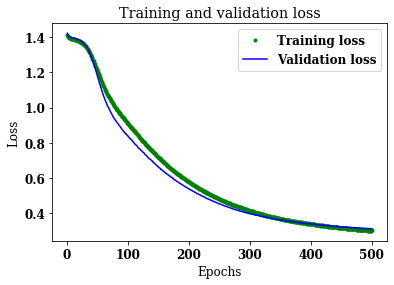

In [9]:
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The graph shows the _loss_ (or the difference between the model's predictions and the actual data) for each epoch. There are several ways to calculate loss, and the method we have used is _categorical_crossentropy_. There is a distinct loss value given for the training and the validation data.

As we can see, the amount of loss initially rapidly decreases, before flattening out. This means that the model is improving and producing more accurate predictions!

## Accuracy vs Epoch

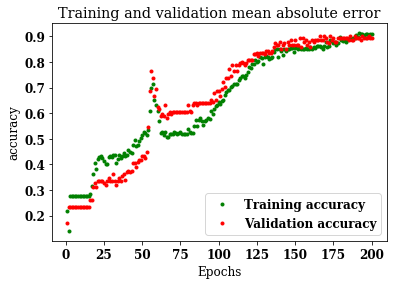

In [10]:
plt.clf()
# Draw a graph of accuracy.
accuracy = history_1.history['accuracy']
val_accuracy = history_1.history['val_accuracy']
SKIP=200
plt.plot(epochs[:SKIP], accuracy[:SKIP], 'g.', label='Training accuracy')
plt.plot(epochs[:SKIP], val_accuracy[:SKIP], 'r.', label='Validation accuracy')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Confusion matrix

Confusion matrix for the training set


array([[57,  2,  0,  3],
       [ 7, 72,  0,  0],
       [ 0,  1, 65,  0],
       [ 1,  0,  0, 77]], dtype=int64)

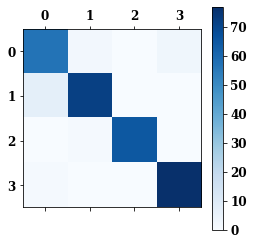

In [11]:
print('Confusion matrix for the training set')
predictions = model_1.predict(x_train)
predictions = np.argmax(predictions, axis=1)
cm=metrics.confusion_matrix(y_train, predictions, labels=None)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
cm

Confusion matrix for the validation set


array([[19,  2,  0,  3],
       [ 2, 31,  0,  0],
       [ 0,  0, 49,  0],
       [ 4,  0,  0, 31]], dtype=int64)

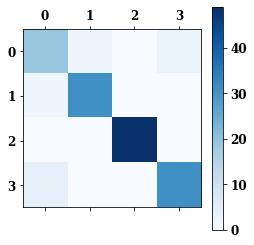

In [12]:
print('Confusion matrix for the validation set')
predictions = model_1.predict(x_test)
predictions = np.argmax(predictions, axis=1)
cm=metrics.confusion_matrix(y_test, predictions, labels=None)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
cm

# Generate a TensorFlow Lite model

## Generate model without quantization
It is possible to quantize a model to reduce it's size.  To keep this example simple, we'll skip that step.

In [13]:
MODELS_DIR = 'FruitFiles/models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
#MODEL_TF = MODELS_DIR + 'model.pb'
#MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_TEMP = MODELS_DIR + 'model.temp'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.h'

In [14]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
model_tflite = converter.convert()

# # Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

2196

## Look at the model size

In [15]:
import os
model_no_quant_size = os.path.getsize(MODEL_TFLITE)
print("Model is %d bytes" % model_no_quant_size)
print('Model location is:', MODEL_TFLITE)

Model is 2196 bytes
Model location is: FruitFiles/models/model.tflite


### 3. Test the models

To prove these models are still accurate after conversion and quantization, we'll use both of them to make predictions and compare these against our test results:

In [16]:
# Instantiate an interpreter
model_2 = tf.lite.Interpreter(MODEL_TFLITE) # read back in the file we saved earlier

# Allocate memory for each model
model_2.allocate_tensors()

input_details = model_2.get_input_details()
output_details = model_2.get_output_details()

# Get the input and output tensors so we can feed in values and get the results
input = model_2.tensor(input_details[0]["index"])
output = model_2.tensor(output_details[0]["index"])

# Create arrays to store the results
tfl_predictions = np.empty(y_test.shape)
#model_predictions = np.empty(x_test.size)

# Run each model's interpreter for each value and store the results in arrays
for i in range(x_test.shape[0]):
  input()[0]=x_test[i].reshape([1,3])[0]
  model_2.invoke()
  tfl_predictions[i] = np.argmax(output()[0])

array([[19,  2,  0,  3],
       [ 2, 31,  0,  0],
       [ 0,  0, 49,  0],
       [ 4,  0,  0, 31]], dtype=int64)

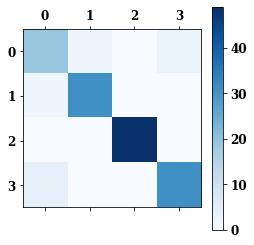

In [17]:
cm=metrics.confusion_matrix(y_test, tfl_predictions, labels=None)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
cm

We can see from the confusion matrix that the model is ready to use.

## Generate a TensorFlow Lite for Microcontrollers model
Convert the TensorFlow Lite quantized model into a C++ source file that can be loaded by TensorFlow Lite for Microcontrollers.  The original "hello_world" for TinyML used Linux xxd and sed commands to translate the file.
We found a Windows version of xxd.exe as part of the [GVIM distribution](https://www.vim.org/).  Look in the VIM installation
directory and copy xxd.exe to your Jupyter working directory if it is not already there.  The sed call has been replaced with equivalent
Python Code.

The output format has been modified to specifically match up with Arduino Nano 33 BLE Sense "Fruit_Classification_Via_Keras" example.

In [18]:
# Install xxd if it is not available
#!apt-get update && apt-get -qq install xxd 

# Convert to a C source file
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_TEMP}

# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
#!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}  # This is the original Linux sed call
with open(MODEL_TFLITE_TEMP, 'rt') as fin:
    with open(MODEL_TFLITE_MICRO, 'wt', encoding='utf-8') as fout:
        for line in fin:
            newLine = line.replace('unsigned char', 'const unsigned char')
            newLine = newLine.replace(REPLACE_TEXT, 'model_data')
            newLine = newLine.replace('model_data[]', 'model_data[] DATA_ALIGN_ATTRIBUTE')
            newLine = newLine.replace('unsigned int', 'const unsigned int')
            fout.write(newLine)
os.remove(MODEL_TFLITE_TEMP)
print('TensorFlow output file = ', MODEL_TFLITE_MICRO)

TensorFlow output file =  FruitFiles/models/model.h


## Deploy to a microcontroller

The original [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) README.md for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview) contained instructions to deploy models on a specific microcontroller.

Our example has already been optimized for use with the Arduino Nano 33 BLE Sense "Fruit_Classification_Via_Keras" example.  Simply overwrite models/model.cpp onto Fruit_Classification_Via_Keras/model.cpp.

In [19]:
with open(MODEL_TFLITE_MICRO, 'rt') as fin:
    for line in fin:
        print(line.replace('\n',''))

const unsigned char model_data[] DATA_ALIGN_ATTRIBUTE = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x3c, 0x08, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x2c, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0xe4, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0xac, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x54, 0x4f, 0x43, 0x4f, 0x20, 0x43, 0x6f, 0x6e,
  0x76, 0x65, 0x72, 0x74, 0x65, 0x64, 0x2e, 0x00, 0x0d, 0x00, 0x00, 0x00,
  0x80, 0x00, 0x00, 0x00, 0x78, 0x00, 0x00, 0x00, 0x6c, 0x00, 0x00, 0x00,
  0x64, 0x00, 0x00, 0x00, 0x5c, 0x00, 0x00, 0x00, 0x54, 0x00, 0x00, 0x00,
  0x4c, 0x00, 0x00, 0x00, 0x40, 0x00, 0x00, 0x00, 0x34, 0x00, 0x00, 0x00,
  0x28, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x0a, 0xf9, 0xff, 0xff, 0x4c